In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [29]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [32]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [33]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
hi_measurement = Base.classes.measurement
hi_station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [36]:
# Display the first row's columns and data in dictionary format
first_row = session.query(hi_station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1623e474770>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0}

In [37]:
# Display the first row's columns and data in dictionary format
first_row = session.query(hi_measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1623e4742f0>,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0}

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set. '
recent_date = session.query(func.max(hi_measurement.date)).scalar()
print("The most recent date in the dataset is:", recent_date)

The most recent date in the dataset is: 2017-08-23


In [39]:
session.query(func.min(hi_measurement.date)).scalar()

'2010-01-01'

In [40]:
latest_yr = dt.date(2017, 8, 23)

In [41]:
days_365 = dt.timedelta(365)

In [42]:
past_year = latest_yr - days_365
past_year

datetime.date(2016, 8, 23)

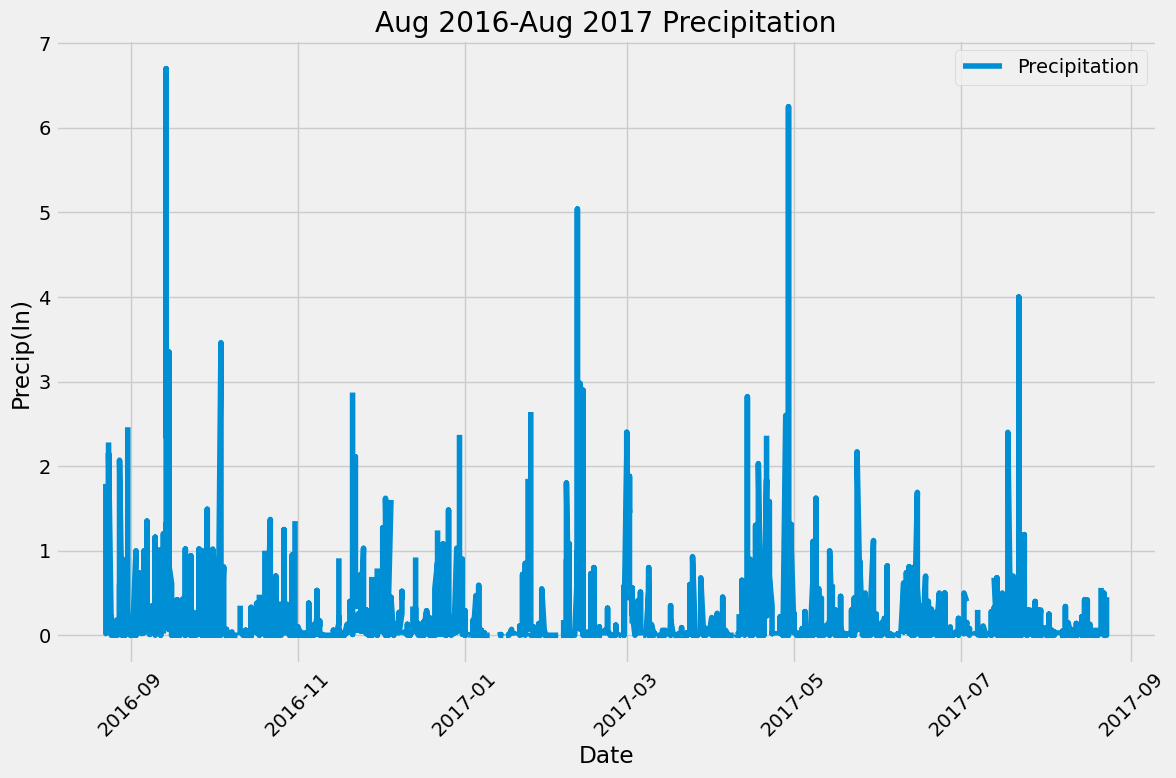

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. == recent_date

# Calculate the date one year from the last date in data set.
past_year = latest_yr - days_365
#print(past_year)

# Perform a query to retrieve the data and precipitation scores how much rain fell aug 2016-aug 2017
one_yr_total = session.query(hi_measurement.prcp, hi_measurement.date).filter(hi_measurement.date >= past_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
hi_precipitation_df = pd.DataFrame(one_yr_total)
hi_precipitation_df = hi_precipitation_df.rename(columns={"prcp": "Precipitation", "date": "Date"})


# Sort the dataframe by date
precip_group_df = hi_precipitation_df.sort_values('Date')
precip_group_df["Date"]=pd.to_datetime(precip_group_df["Date"])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 8))
plt.plot(precip_group_df['Date'], precip_group_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precip(In)')
plt.title('Aug 2016-Aug 2017 Precipitation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data 
date_sort.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [45]:
# Design a query to calculate the total number of stations in the dataset  
station_count = session.query(hi_station).group_by(hi_station.station).count()
station_count

9

In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_station = session.query(hi_measurement.station, func.count(hi_measurement.station))\
    .group_by(hi_measurement.station)\
    .order_by(func.count(hi_measurement.station).desc()).all()
active_station

for station_name, count in active_station:
    print(f"{station_name}, {count}")
                         

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_station[0][0]
temp_summary = session.query(func.min(hi_measurement.tobs), func.max(hi_measurement.tobs), func.avg(hi_measurement.tobs))\
        .filter(hi_measurement.station == most_active_station).\
        all()

lowest_temp, highest_temp, avg_temp = temp_summary[0]

print(f"station {most_active_station}")
print(f"Lowest temperature: {lowest_temp}")
print(f"Highest temperature: {highest_temp}")
print(f"Average temperature: {avg_temp}")


station USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


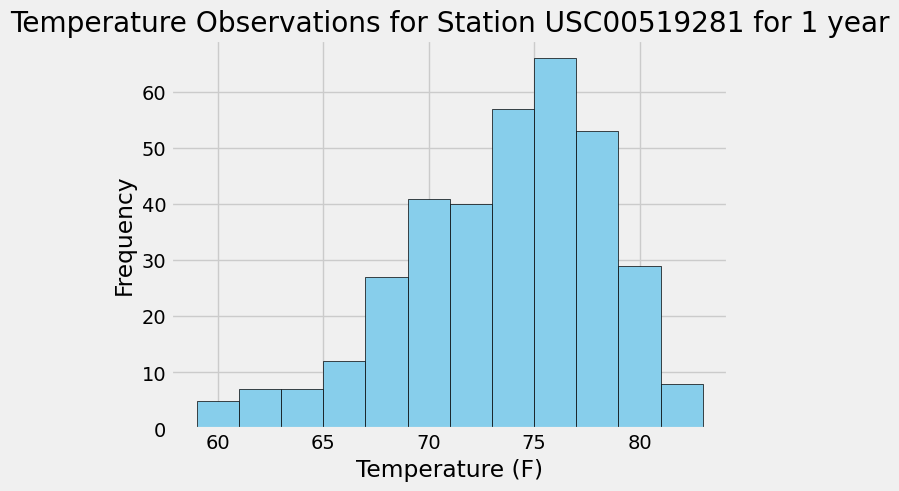

In [48]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
# Use Pandas to run the SQL query and store the results in a DataFrame

temp_data = session.query(hi_measurement.tobs)\
    .filter(hi_measurement.station == most_active_station)\
    .filter(hi_measurement.date >= past_year)\
    .all()

# temp_df = pd.DataFrame(temp_data)

temperatures = [temp[0] for temp in temp_data]

# and plot the results as a histogram
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station USC00519281 for 1 year')
plt.show()

# Close Session

In [49]:
# Close Session
session.close()

In [24]:
date_index = precip_group_df.set_index("Date")["Precipitation"].to_dict()
date_index

{Timestamp('2016-08-23 00:00:00'): 0.02,
 Timestamp('2016-08-24 00:00:00'): 2.15,
 Timestamp('2016-08-25 00:00:00'): 0.08,
 Timestamp('2016-08-26 00:00:00'): 0.0,
 Timestamp('2016-08-27 00:00:00'): nan,
 Timestamp('2016-08-28 00:00:00'): 2.07,
 Timestamp('2016-08-29 00:00:00'): 0.35,
 Timestamp('2016-08-30 00:00:00'): 0.0,
 Timestamp('2016-08-31 00:00:00'): 0.25,
 Timestamp('2016-09-01 00:00:00'): 0.0,
 Timestamp('2016-09-02 00:00:00'): 0.19,
 Timestamp('2016-09-03 00:00:00'): 0.07,
 Timestamp('2016-09-04 00:00:00'): 0.44,
 Timestamp('2016-09-05 00:00:00'): 0.18,
 Timestamp('2016-09-06 00:00:00'): 0.04,
 Timestamp('2016-09-07 00:00:00'): 0.23,
 Timestamp('2016-09-08 00:00:00'): 0.0,
 Timestamp('2016-09-09 00:00:00'): 0.16,
 Timestamp('2016-09-10 00:00:00'): 0.09,
 Timestamp('2016-09-11 00:00:00'): 0.6,
 Timestamp('2016-09-12 00:00:00'): 0.15,
 Timestamp('2016-09-13 00:00:00'): 0.37,
 Timestamp('2016-09-14 00:00:00'): nan,
 Timestamp('2016-09-15 00:00:00'): 0.83,
 Timestamp('2016-09-16 

In [ ]:
# Potential joint table for Climate app?
sel = [hi_measurement.station, hi_measurement.prcp, hi_measurement.date, hi_measurement.tobs]
same_station = session.query(*sel).filter(hi_measurement.station == hi_station.station).limit(20).all()
same_station